# Lab: Trees and Model Stability

Trees are notorious for being **unstable**: Small changes in the data can lead to noticeable or large changes in the tree. We're going to explore this phenomenon, and a common rebuttal.

In the folder for this lab, there are three datasets that we used in class: Divorce, heart failure, and the AirBnB price dataset.

1. Pick one of the datasets and appropriately clean it.
2. Perform a train-test split for a specific seed (save the seed for reproducibility). Fit a classification/regression tree and a linear model on the training data and evaluate their performance on the test data. Set aside the predictions these models make.
3. Repeat step 2 for three to five different seeds (save the seeds for reproducibility). How different are the trees that you get? Your linear model coefficients?. Set aside the predictions these models make.

Typically, you would see the trees changing what appears to be a non-trivial amount, while the linear model coefficients don't vary nearly as much. Often, the changes appear substantial. 

But are they?

4. Instead of focusing on the tree or model coefficients, do three things:
    1. Make scatterplots of the predicted values on the test set from question 2 against the predicted values for the alternative models from part 3, separately for your trees and linear models. Do they appear reasonably similar?
    2. Compute the correlation between your model in part 2 and your alternative models in part 3, separately for your trees and linear models. Are they highly correlated or not?
    3. Run a simple linear regression of the predicted values on the test set from the alternative models on the predicted values from question 2, separately for your trees and linear models. Is the intercept close to zero? Is the slope close to 1? Is the $R^2$ close to 1?

5. Do linear models appear to have similar coefficients and predictions across train/test splits? Do trees?
6. True or false, and explain: "Even if the models end up having a substantially different appearance, the predictions they generate are often very similar."

## 1.

In [43]:
import pandas as pd
path = "data/airbnb_hw.csv"
df = pd.read_csv(path)
df.head()

,Host Id,Host Since,Name,Neighbourhood,Property Type,Review Scores Rating (bin),Room Type,Zipcode,Beds,Number of Records,Number Of Reviews,Price,Review Scores Rating
0,5162530,NaN,1 Bedroom in Prime Williamsburg,Brooklyn,Apartment,NaN,Entire home/apt,11249.0,1.0,1,0,145,NaN
1,33134899,NaN,"Sunny, Private room in Bushwick",Brooklyn,Apartment,NaN,Private room,11206.0,1.0,1,1,37,NaN
2,39608626,NaN,Sunny Room in Harlem,Manhattan,Apartment,NaN,Private room,10032.0,1.0,1,1,28,NaN
3,500,6/26/2008,Gorgeous 1 BR with Private Balcony,Manhattan,Apartment,NaN,Entire home/apt,10024.0,3.0,1,0,199,NaN
4,500,6/26/2008,Trendy Times Square Loft,Manhattan,Apartment,95.0,Private room,10036.0,3.0,1,39,549,96.0


In [44]:
df_clean = df.copy()
df_clean["Price"] = pd.to_numeric(df_clean["Price"], errors="coerce") # converting Price to numeric
df_clean = df_clean.dropna(subset=["Price"])
df_clean = df_clean.drop(columns=["Host Id", "Host Since", "Name"]) # dropping irrelevant columns

numeric_cols = df_clean.select_dtypes(include=["number"]).columns.tolist()
numeric_cols.remove("Price")  # keeping as target

cat_cols = df_clean.select_dtypes(include=["object"]).columns.tolist()

for col in numeric_cols:
    df_clean[col] = df_clean[col].fillna(df_clean[col].median())

for col in cat_cols:
    df_clean[col] = df_clean[col].fillna("Unknown")

# encoding categorical variables
df_model = pd.get_dummies(df_clean, columns=cat_cols, drop_first=True)

X = df_model.drop(columns=["Price"])
y = df_model["Price"]

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: (30297, 31)
Target shape: (30297,)


## 2.

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

seed = 0  # example seed to save for reproducibility
set_seed = 0

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=set_seed
)

tree = DecisionTreeRegressor(random_state=seed)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)

lin = LinearRegression()
lin.fit(X_train, y_train)
y_pred_lin = lin.predict(X_test)

r2_tree = r2_score(y_test, y_pred_tree)
rmse_tree = np.sqrt(mean_squared_error(y_test, y_pred_tree))

r2_lin = r2_score(y_test, y_pred_lin)
rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred_lin))

# evaluating just these results
predictions = {
    (seed, "tree"): y_pred_tree,
    (seed, "linear"): y_pred_lin
}
print(f"Decision Tree - R2: {r2_tree:.4f}, RMSE: {rmse_tree:.4f}")
print(f"Linear Regression - R2: {r2_lin:.4f}, RMSE: {rmse_lin:.4f}")


Decision Tree - R2: 0.1908, RMSE: 99.6866
Linear Regression - R2: 0.4139, RMSE: 84.8382


The linear model outperforms the basic decision tree in this scenario.

## 3.

In [46]:
seeds = [0, 7, 42, 99, 2025]

results = []
lin_coefs = {}
tree_stats = {}
predictions = {}

for seed in seeds:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=set_seed
    )
    
    tree = DecisionTreeRegressor(random_state=seed)
    tree.fit(X_train, y_train)
    y_pred_tree = tree.predict(X_test)
    
    lin = LinearRegression()
    lin.fit(X_train, y_train)
    y_pred_lin = lin.predict(X_test)
    
    # metrics
    r2_tree = r2_score(y_test, y_pred_tree)
    rmse_tree = np.sqrt(mean_squared_error(y_test, y_pred_tree))

    r2_lin = r2_score(y_test, y_pred_lin)
    rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred_lin))
    
    results.append({
        "seed": seed,
        "r2_tree": r2_tree,
        "rmse_tree": rmse_tree,
        "r2_lin": r2_lin,
        "rmse_lin": rmse_lin,
        "tree_depth": tree.get_depth(),
        "tree_n_leaves": tree.get_n_leaves()
    })
    
    # saving coefficients and tree stats
    lin_coefs[seed] = pd.Series(lin.coef_, index=X.columns)
    tree_stats[seed] = {
        "depth": tree.get_depth(),
        "n_leaves": tree.get_n_leaves()
    }
    
    # saving predictions
    predictions[(seed, "tree")] = y_pred_tree
    predictions[(seed, "linear")] = y_pred_lin

results_df = pd.DataFrame(results)
print(results_df)


   seed   r2_tree  rmse_tree    r2_lin   rmse_lin  tree_depth  tree_n_leaves
0     0  0.190795  99.686602  0.413905  84.838221          32          12760
1     7  0.195144  99.418378  0.413905  84.838221          32          12758
2    42  0.191125  99.666305  0.413905  84.838221          32          12760
3    99  0.201570  99.020678  0.413905  84.838221          32          12759
4  2025  0.188481  99.829060  0.413905  84.838221          32          12758


The trees are a bit different since the depth ranges from 32 to 34 but the number of leaves is always very large (~12.7k – 12.9k).

That tells us that all trees grow very deep and are highly branched on the training split and these different seeds give us slightly different splits (depth and leaves vary a bit), but all trees are similarly complex and overfit ish.

So yes, the exact splits and leaf structure are slightly different, but overall complexity and performance are fairly similar across seeds.

In [47]:
coef_df = pd.DataFrame(lin_coefs)  # rows = features cols = seeds
coef_summary = pd.DataFrame({
    "coef_mean": coef_df.mean(axis=1),
    "coef_std": coef_df.std(axis=1),
    "min_coef": coef_df.min(axis=1),
    "max_coef": coef_df.max(axis=1) 
}).sort_values("coef_std", ascending=False)

coef_summary.head(10)


,coef_mean,coef_std,min_coef,max_coef
Property Type_Chalet,54.245773,7.944109e-15,54.245773,54.245773
Property Type_Loft,51.844415,7.944109e-15,51.844415,51.844415
Property Type_Villa,14.656218,1.986027e-15,14.656218,14.656218
Review Scores Rating (bin),-3.320937,0.000000e+00,-3.320937,-3.320937
Room Type_Private room,-80.707886,0.000000e+00,-80.707886,-80.707886
Property Type_Unknown,-83.774869,0.000000e+00,-83.774869,-83.774869
Property Type_Treehouse,73.073847,0.000000e+00,73.073847,73.073847
Property Type_Townhouse,2.756201,0.000000e+00,2.756201,2.756201
Property Type_Tent,55.477366,0.000000e+00,55.477366,55.477366
Property Type_Other,47.486938,0.000000e+00,47.486938,47.486938


As for the linear model coefficients, some categories (like Property Type_Lighthouse, Property Type_Treehouse, Property Type_Hut) were rare and show large variation in coefficients across seeds (high coef_std), because they have very few listings and small changes in the train/test split can change their estimated effect a lot.

More common predictors (like Beds, Review Scores Rating, etc) generally have much smaller standard deviations in their coefficients across seeds so it means that those effects are more stable.

## Q4

### Q4.1

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

In [49]:
initial_tree = predictions.pop((0, "tree"))
initial_linear = predictions.pop((0, "linear")) 

#### Linear Model Scatterplots

To answer the question - for the linear models, they are band for band the same since LinReg just formulaically finds the best with no randomness, so they're the same.

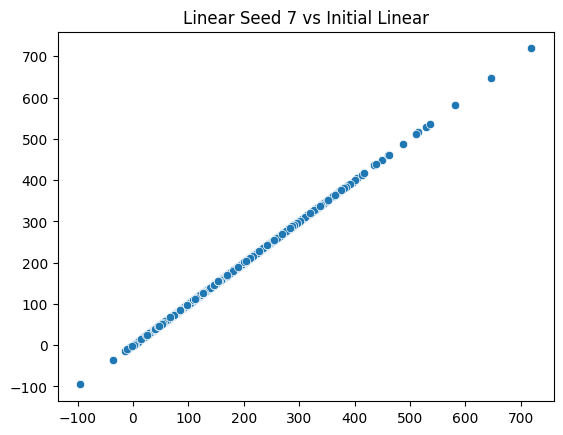

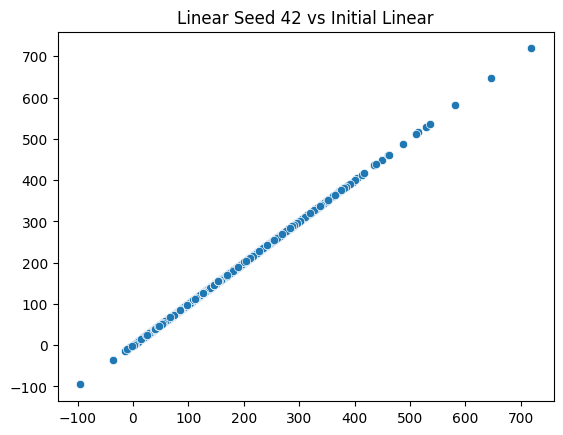

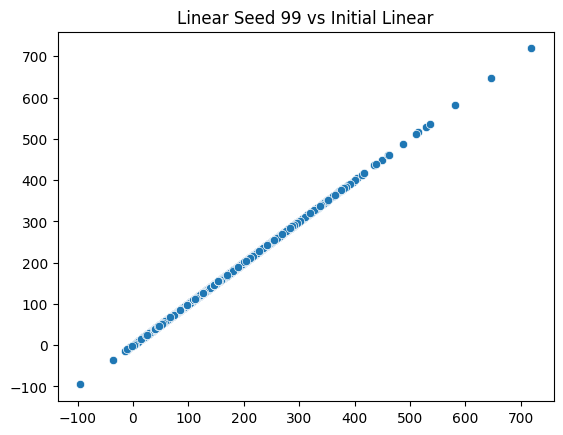

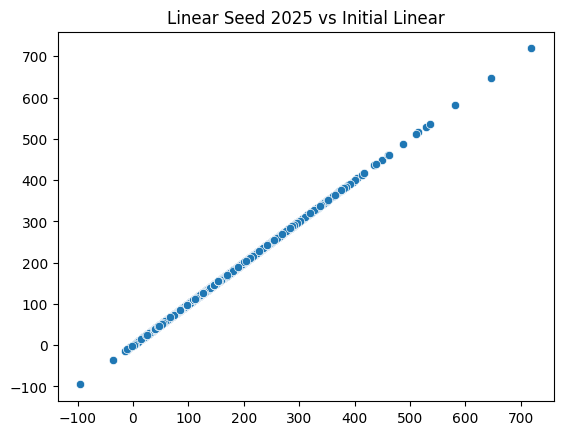

In [50]:
for key, preds in predictions.items():
    seed, model_type = key
    if model_type == "linear":
        sns.scatterplot(x=initial_linear, y=preds)
        plt.title(f"Linear Seed {seed} vs Initial Linear")
        plt.show()

#### Tree Model Scatterplots

For the tree models, we can see that they're still reasonably similar but there are a few noticeable differences but not as volatile.

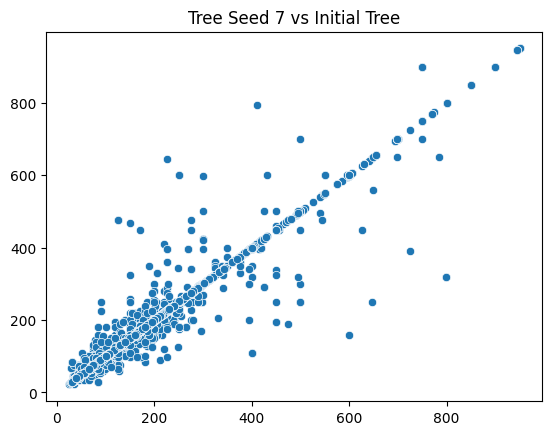

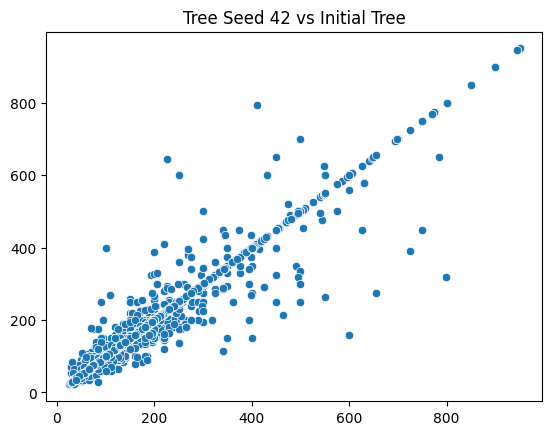

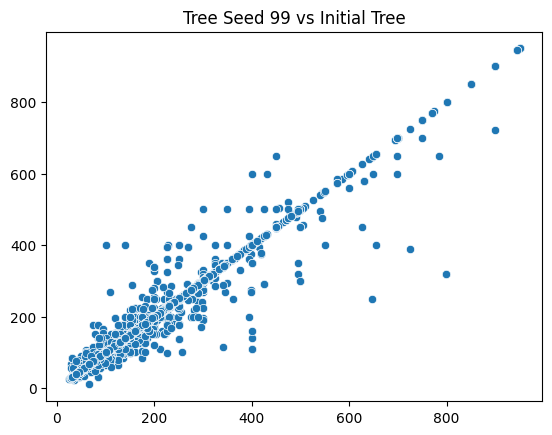

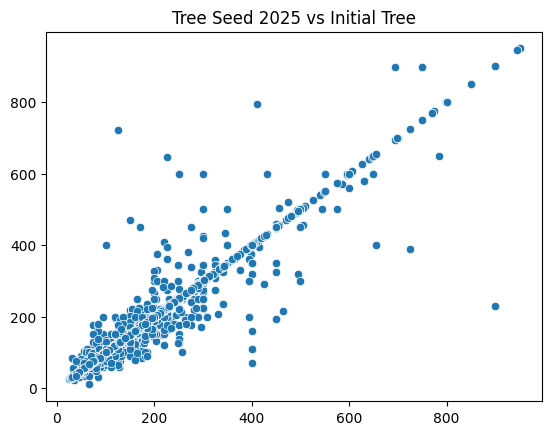

In [51]:
for key, preds in predictions.items():
    seed, model_type = key
    if model_type == "tree":
        sns.scatterplot(x=initial_tree, y=preds)
        plt.title(f"Tree Seed {seed} vs Initial Tree")
        plt.show()

### Q4.2

For the linear models, obviously the correlation is almost 1 because they're the exact same predictions. For the tree models, they're highly correlated.

In [52]:
linear_correlations = {}
for key, preds in predictions.items():
    seed, model_type = key
    if model_type == "linear":
        linear_correlations[seed] = np.corrcoef(initial_linear, preds)[0, 1]

linear_correlations

{7: np.float64(0.9999999999999998),
 42: np.float64(0.9999999999999998),
 99: np.float64(0.9999999999999998),
 2025: np.float64(0.9999999999999998)}

In [53]:
tree_correlations = {}
for key, preds in predictions.items():
    seed, model_type = key
    if model_type == "tree":
        tree_correlations[seed] = np.corrcoef(initial_tree, preds)[0, 1]

tree_correlations

{7: np.float64(0.9788912295393396),
 42: np.float64(0.9812984654945087),
 99: np.float64(0.9842605492334395),
 2025: np.float64(0.9790398788100643)}

### Q4.3

The linear regressions have an R^2 and slope of 1 exactly. The intercept is close to 0. For the trees the R^2 and slope is close to 1, but not quite there - the intercept is a bit off from 0.

In [54]:
from sklearn.linear_model import LinearRegression

Seed 7:
Intercept: 8.526512829121202e-14
Coefficient: [1.]
R^2: 1.0


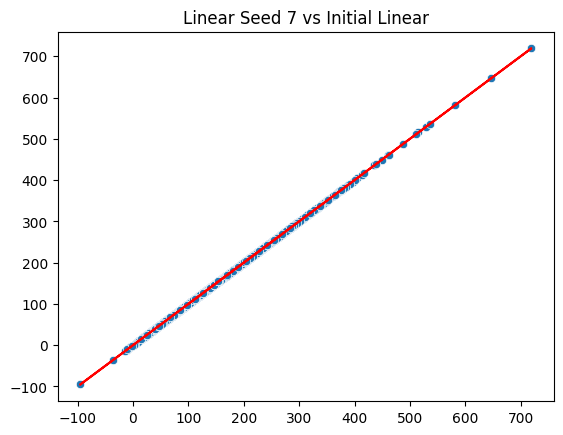

Seed 42:
Intercept: 8.526512829121202e-14
Coefficient: [1.]
R^2: 1.0


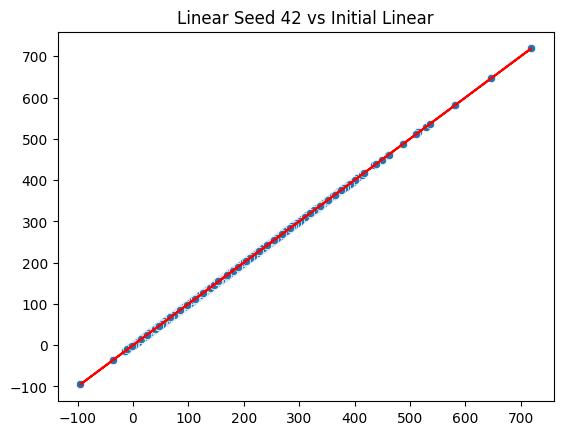

Seed 99:
Intercept: 8.526512829121202e-14
Coefficient: [1.]
R^2: 1.0


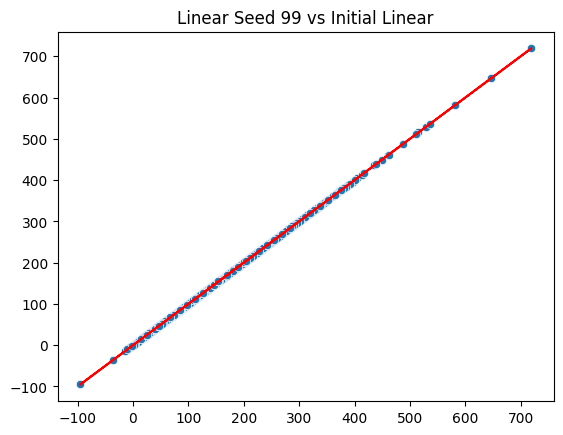

Seed 2025:
Intercept: 8.526512829121202e-14
Coefficient: [1.]
R^2: 1.0


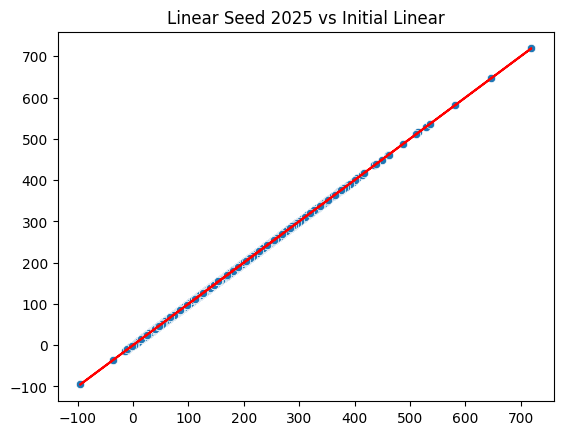

In [55]:
for key, preds in predictions.items():
    seed, model_type = key
    if model_type == "linear":
        sns.scatterplot(x=initial_linear, y=preds)
        reshaped_initial = initial_linear.reshape(-1, 1)
        model = LinearRegression().fit(reshaped_initial, preds)
        print(f"Seed {seed}:")
        print(f"Intercept: {model.intercept_}")
        print(f"Coefficient: {model.coef_}")
        print(f"R^2: {model.score(reshaped_initial, preds)}")
        plt.title(f"Linear Seed {seed} vs Initial Linear")
        plt.plot(initial_linear, model.predict(reshaped_initial), color='red')
        plt.show()

Seed 7:
Intercept: 3.291533761923688
Coefficient: [0.98043298]
R^2: 0.9582280392690403


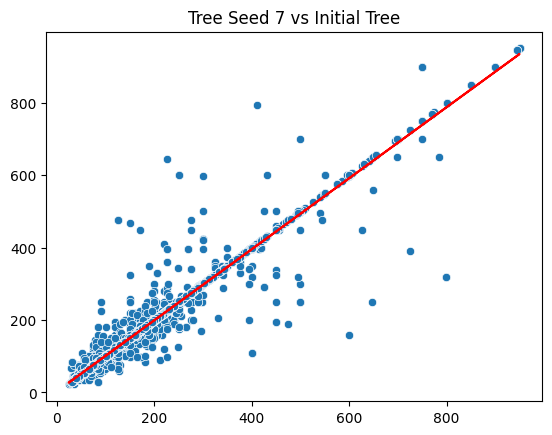

Seed 42:
Intercept: 4.040993451331559
Coefficient: [0.97171555]
R^2: 0.9629466783818774


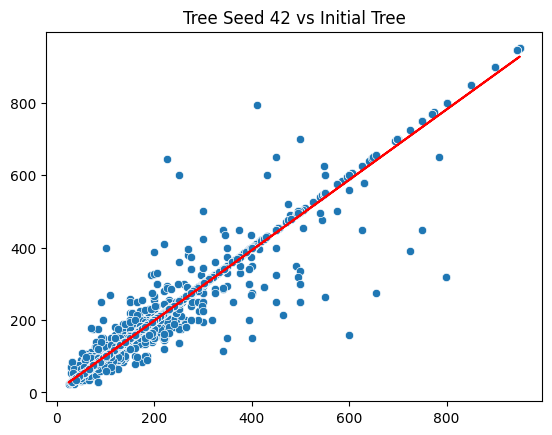

Seed 99:
Intercept: 3.7539287028565695
Coefficient: [0.97331243]
R^2: 0.9687688287773119


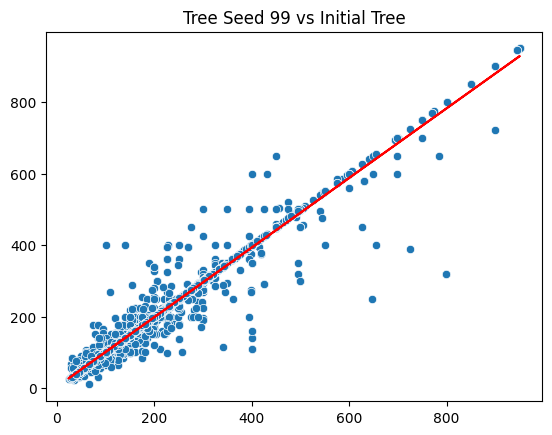

Seed 2025:
Intercept: 2.6459318546076247
Coefficient: [0.98341289]
R^2: 0.9585190843004248


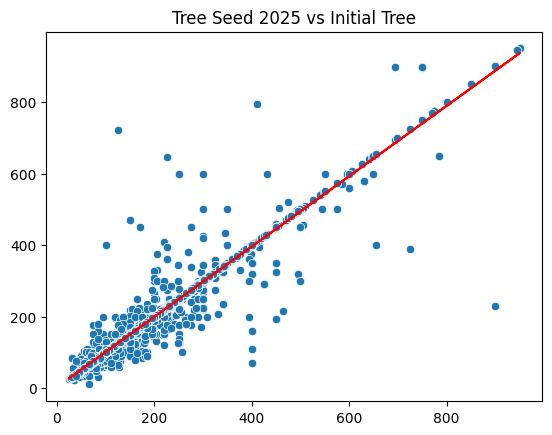

In [56]:
for key, preds in predictions.items():
    seed, model_type = key
    if model_type == "tree":
        sns.scatterplot(x=initial_tree, y=preds)
        model = LinearRegression().fit(initial_tree.reshape(-1, 1), preds)
        print(f"Seed {seed}:")
        print(f"Intercept: {model.intercept_}")
        print(f"Coefficient: {model.coef_}")
        print(f"R^2: {model.score(initial_tree.reshape(-1, 1), preds)}")
        plt.title(f"Tree Seed {seed} vs Initial Tree")
        plt.plot(initial_tree, model.predict(initial_tree.reshape(-1, 1)), color='red')
        plt.show()